# Heat Wave and Cold Spells

Dieses Skript verarbeitet den Datensatz "Heat Wave Days" aus dem Copernics Climate Data Store. Der Datensatz enthält die Anzahl der Hitzewellen-Tage (Heat wave days; HWD), die mit verschiedenen europaweiten sowie nationalen/regionalen Definitionen im Rahmen des C3S European Health Service entwickelt wurden. Diese Tage sind für unterschiedliche zukünftige Zeiträume und Klimawandelszenarien verfügbar.

**Informationen zum Datensatz**: 

* Source: [Heat Wave and Cold Spells](https://cds.climate.copernicus.eu/datasets/sis-heat-and-cold-spells?tab=overview)
* Author: T. Tewes (Stadt Konstanz) 
* Resolution: 0.1° x 0.1°
* Notebook-Version: 1.2 (Updated: December 18, 2024)

## 1. Specifying the paths and working directories

In [1]:
import os

''' ---- Hier die Verzeichnisse angeben ---- '''
download_folder = r".\data\sis-heat-and-cold-spells\download"
working_folder = r".\data\sis-heat-and-cold-spells\working"
geotiff_folder = r".\data\sis-heat-and-cold-spells\geotiff"
csv_folder = r".\data\sis-heat-and-cold-spells\csv"
output_folder = r".\data\sis-heat-and-cold-spells\output"
''' ----- Ende der Eingaben ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Download and Extract Dataset

### 2.1 API Authentication

In [2]:
import cdsapi

def main():
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Request Definition and Download

In [3]:
# Define additional request fields to ensure the request stays within the file size limit.
# These coordinates were obtained using the BBox Extractor tool:
# https://str-ucture.github.io/bbox-extractor/

bbox_wgs84_deutschland = [56.0, 5.8, 47.2, 15.0]
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]

# Alternatively, use a shapefile for precise geographic filtering
import geopandas as gpd
import math

# Example: Load shapefile of Konstanz (WGS84 projection)
de_shapefile = r"./shapefiles/de_boundary.shp"
de_gdf = gpd.read_file(de_shapefile)
de_bounds = de_gdf.total_bounds

# Adjust and buffer
de_bounds_adjusted = [(math.floor(de_bounds[0]* 10)/10)-0.1,
                      (math.floor(de_bounds[1]* 10)/10)-0.1,
                      (math.ceil(de_bounds[2]* 10)/10)+0.1,
                      (math.ceil(de_bounds[3]* 10)/10)+0.1]

bbox_de_bounds_adjusted = [de_bounds_adjusted[3], de_bounds_adjusted[0],
                           de_bounds_adjusted[1], de_bounds_adjusted[2]]

In [4]:
variable_list = ['heat_wave_days', 'cold_spell_days']
definition_list = ['climatological_related', 'health_related', 'country_related']

selected_definition = definition_list[1]

# Since. cold_spell_days is only available with country_related definition
# And heat_wave_days is available for all definitions.
if selected_definition in ["climatological_related", "health_related"]:
    selected_variable = variable_list[0]
elif selected_definition == "country_related":
    selected_variable = variable_list

print(f"selected_definition: {selected_definition} \nselected_variable: {selected_variable}")

selected_definition: health_related 
selected_variable: heat_wave_days


In [5]:
dataset = "sis-heat-and-cold-spells"
request = {
    "variable": selected_variable,
    "definition": selected_definition,
    "experiment": [
        "rcp4_5",
        "rcp8_5"
    ],
    "ensemble_statistic": [
        "ensemble_members_average",
        "ensemble_members_standard_deviation"
    ],
    "area": bbox_de_bounds_adjusted
}

In [6]:
# Run this cell to download the dataset:

def main_retrieve():
    dataset_filename = f"{dataset}-{selected_definition}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)

    # Download the dataset only if the dataset has not been downloaded before
    if not os.path.isfile(dataset_filepath):
        # Download the dataset with the defined request parameters
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Dataset already downloaded.")

if __name__ == "__main__":
    client = main()
    main_retrieve()

2025-02-20 10:15:59,241 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


2025-02-20 10:15:59,242 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


Dataset already downloaded.


### 2.3 Extract the Zip folder

In [7]:
import zipfile

extract_folder = os.path.join(working_folder, f"{selected_definition}")
os.makedirs(extract_folder, exist_ok=True)

# Extract the zip file
try:
    if not os.listdir(extract_folder):
        dataset_filename = f"{dataset}-{selected_definition}.zip"
        dataset_filepath = os.path.join(download_folder, dataset_filename)
        
        with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Successfully extracted files to: {extract_folder}")
    else:
        print("Folder is not empty. Skipping extraction.")
except FileNotFoundError:
    print(f"Error: The file {dataset_filepath} was not found.")
except zipfile.BadZipFile:
    print(f"Error: The file {dataset_filepath} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Folder is not empty. Skipping extraction.


## 3. Read the netCDF file and print the metadata

⚠️ <span style="background-color: red; color: white; padding: 2px 4px;">Important</span>: After downloading the datasets, update the **selected_definition** in the code block below to proceed with analysis, data extraction, and visualization.

In [8]:
# Modify the selected period here
selected_definition = definition_list[0] # 0: climatological_related, 1: health_related, 2: country_related
print(selected_definition)

extract_folder = os.path.join(working_folder, selected_definition)

climatological_related


### 3.1 Create a Dataframe of Available netCDF Files

In [9]:
import re
import pandas as pd
import netCDF4 as nc

def meta(filename):
    match = re.search(r"(?P<ds_variable>\w+?)_(?P<ds_definition>\w+?)_(?P<rcp>rcp\d+?)_(?P<rcp_statistic>mean|stdev)_v(\d+\.\d+)\.", filename)
    if not match:
        raise ValueError("the given filename does not fit the expected naming scheme")
    
    def get_nc_variable():
        with nc.Dataset(os.path.join(extract_folder, filename), 'r') as nc_dataset:
            nc_variable_name = nc_dataset.variables.keys()
            return [*nc_variable_name][0]
    
    return dict(
        filename=filename,
        path=os.path.join(extract_folder, filename),
        ds_variable=match.group('ds_variable'),
        ds_definition=match.group('ds_definition'),
        variable_name=get_nc_variable(),
        rcp=match.group('rcp'),
        rcp_statistic=match.group('rcp_statistic')
    )

# Beispielverzeichnis (angepasst an deine Umgebung)
nc_files = [meta(f) for f in os.listdir(extract_folder) if f.endswith('.nc')]
df_nc_files = pd.DataFrame.from_dict(nc_files)

# Modify pandas display options
pd.options.display.max_colwidth = 30

# Display the DataFrame without displaying path
df_nc_files.loc[:, df_nc_files.columns != 'path']

,filename,ds_variable,ds_definition,variable_name,rcp,rcp_statistic
0,HWD_EU_climate_rcp45_mean_...,HWD,EU_climate,HWD_EU_climate,rcp45,mean
1,HWD_EU_climate_rcp45_stdev...,HWD,EU_climate,HWD_EU_climate,rcp45,stdev
2,HWD_EU_climate_rcp85_mean_...,HWD,EU_climate,HWD_EU_climate,rcp85,mean
3,HWD_EU_climate_rcp85_stdev...,HWD,EU_climate,HWD_EU_climate,rcp85,stdev


### 3.1 Print unique Variable name(s) and Available Variables

In [10]:
import netCDF4 as nc

seen_variables = set()
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    if variable_name in seen_variables:
        continue

    # Open the NetCDF file in read mode
    nc_dataset = nc.Dataset(nc_file['path'], mode='r')

    # List all variables in the dataset
    variables_list = nc_dataset.variables.keys()
    print(f"{i+1:<2} {variable_name:<15}: Available variables: {list(variables_list)}")
    
    # Add the variable name to the seen set
    seen_variables.add(variable_name)

1  HWD_EU_climate : Available variables: ['HWD_EU_climate', 'height', 'quantile', 'lat', 'lon', 'time']


In [11]:
import netCDF4 as nc
import pandas as pd

nc_file = nc_files[0]
nc_dataset = nc.Dataset(nc_file['path'], mode='r')
variables_list = list(nc_dataset.variables.keys())

rows = []
for test_var in variables_list:
    try:
        var_obj = nc_dataset.variables[test_var]
        unit = getattr(var_obj, 'units', 'N/A')
        shape = var_obj.shape
        rows.append({
            "nc_variables": test_var,
            "unit": unit,
            "shape": shape
        })
    except Exception as e:
        print(f"Error processing variable {test_var}: {e}")

# Create a DataFrame
df = pd.DataFrame(rows)
df

,nc_variables,unit,shape
0,HWD_EU_climate,day,"(100, 82, 95)"
1,height,m,()
2,quantile,N/A,()
3,lat,degrees_north,"(82,)"
4,lon,degrees_east,"(95,)"
5,time,days since 1986-01-01,"(100,)"


In [12]:
seen_variables = set()
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    if variable_name in seen_variables:
        continue
    
    nc_dataset = nc.Dataset(nc_file['path'], mode='r')
    variable_data = nc_dataset[variable_name]
    
    # Generate summary of the primary variable
    summary = {
        "Variable Name": variable_name,
        "Data Type": variable_data.dtype,
        "Shape": variable_data.shape,
        "Variable Info": f"{variable_data.dimensions}",
        "Units": getattr(variable_data, "units", "N/A"),
        "Long Name": getattr(variable_data, "long_name", "N/A"),
    }
    
    # Display dataset summary as a DataFrame for better visualization
    nc_summary = pd.DataFrame(list(summary.items()), columns=['Description', 'Remarks'])

    # Display the summary DataFrame
    print(f"{i+1}.")
    display(nc_summary)
    
    # Add the variable name to the seen set
    seen_variables.add(variable_name)
    if len(seen_variables)>=2:
        print("....")
        break

1.


,Description,Remarks
0,Variable Name,HWD_EU_climate
1,Data Type,float32
2,Shape,"(100, 82, 95)"
3,Variable Info,"('time', 'lat', 'lon')"
4,Units,day
5,Long Name,Ensemble members average n...


## 4. Export Dataset to CSV

In [13]:
# Gpt optimized
import numpy as np
import pandas as pd
import netCDF4 as nc

def netcdf_to_dataframe(nc_file, bounding_box=None):
    """
    Converts a netCDF file to a DataFrame, optionally filtering by a bounding box.
    
    Parameters:
        nc_file (dict): Dictionary with keys.
        bounding_box (list): Bounding box as [lon_min, lat_min, lon_max, lat_max] (optional).
        
    Returns:
        pd.DataFrame: DataFrame with time, latitude, longitude, and the variable's values.
    """
    # Open the netCDF file
    with nc.Dataset(nc_file['path'], 'r') as nc_dataset:
        lon = nc_dataset['lon'][:]
        lat = nc_dataset['lat'][:]
        
        # Extract time and convert it to readable dates
        time_var = nc_dataset.variables['time']
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)

        # Extract variable data
        variable_data = nc_dataset.variables[nc_file['variable_name']]

        # Filter by bounding box if provided
        if bounding_box:
            lon_min, lat_min, lon_max, lat_max = bounding_box
            lat_mask = (lat >= lat_min) & (lat <= lat_max)
            lon_mask = (lon >= lon_min) & (lon <= lon_max)

            lat_indices = np.where(lat_mask)[0]
            lon_indices = np.where(lon_mask)[0]

            filtered_lat = lat[lat_indices]
            filtered_lon = lon[lon_indices]
            variable_data_subset = variable_data[:, lat_indices, :][:, :, lon_indices]
        else:
            filtered_lat = lat
            filtered_lon = lon
            variable_data_subset = variable_data[:]

    # Flatten the data using NumPy
    """Modify the variable_column_name to reuse the function"""
    time_size, lat_size, lon_size = variable_data_subset.shape
    variable_column_name = f"{nc_file['variable_name']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}"
    
    # Masked values will be excluded automatically
    masked_data = variable_data_subset.filled(np.nan)  # Fill masked values with NaN
    valid_mask = ~np.isnan(masked_data)

    # Generate time, latitude, longitude mesh grids
    time_grid, lat_grid, lon_grid = np.meshgrid(
        cftime, filtered_lat, filtered_lon, indexing='ij'
    )

    # Extract valid (non-NaN) data
    time_flat = time_grid[valid_mask]
    lat_flat = lat_grid[valid_mask]
    lon_flat = lon_grid[valid_mask]
    values_flat = masked_data[valid_mask]

    # Construct a DataFrame
    df = pd.DataFrame({
        'time': time_flat,
        'latitude': lat_flat,
        'longitude': lon_flat,
        variable_column_name: values_flat
    })

    # Convert time to datetime
    df['time'] = pd.to_datetime(df['time'].astype(str))

    # Set the index
    return df.set_index(['time', 'latitude', 'longitude'])

### 4.1 Create DataFrame and Export as merged CSV file

In [14]:
from tqdm.notebook import tqdm
import textwrap

csv_filename = f"{selected_definition}_{nc_files[0]['variable_name']}.csv.zip"
csv_path = os.path.join(csv_folder, csv_filename)

if not os.path.isfile(csv_path):
    dataframes = [netcdf_to_dataframe(nc_file) for nc_file in tqdm(nc_files)]
    df_merged = pd.concat(dataframes, axis=1)
    df_merged.to_csv(csv_path, sep=',', encoding='utf8', compression='zip')
else:
    print(f"File already exists at {csv_path}. Skipping export.")
    print("Reading existing CSV file...")
    df_merged = pd.read_csv(csv_path).set_index(['time', 'latitude', 'longitude'])
    
def wrap_column_names(df, width):
    wrapped_columns = {col: " ".join(textwrap.wrap(col, width)) for col in df.columns}
    return df.rename(columns=wrapped_columns)
    
# Modify pandas display options
pd.options.display.float_format = '{:,.2f}'.format
    
# Display DataFrame
df_wrapped = wrap_column_names(df_merged, width=14)
df_wrapped

File already exists at .\data\sis-heat-and-cold-spells\csv\climatological_related_HWD_EU_climate.csv.zip. Skipping export.
Reading existing CSV file...


HWD_EU_climate _rcp45_mean  \
time       latitude longitude                               
1986-01-01 47.10    5.70                             0.77   
                    5.80                             0.76   
                    5.90                             0.77   
                    6.00                             0.74   
                    6.10                             0.72   
...                                                   ...   
2085-01-01 55.20    14.70                            3.60   
                    14.80                            2.84   
                    14.90                            2.58   
                    15.00                            3.00   
                    15.10                            3.43   

                               HWD_EU_climate _rcp45_stdev  \
time       latitude longitude                                
1986-01-01 47.10    5.70                              1.33   
                    5.80                              1.31   
                    5.90                              1.18   
                    6.00                              0.96   
                    6.10                              0.80   
...                                                    ...   
2085-01-01 55.20    14.70                             2.06   
                    14.80                             1.80   
                    14.90                             1.48   
                    15.00                             1.58   
                    15.10                             2.30   

                               HWD_EU_climate _rcp85_mean  \
time       latitude longitude                               
1986-01-01 47.10    5.70                             0.77   
                    5.80                             0.76   
                    5.90                             0.77   
                    6.00                             0.74   
                    6.10                             0.72   
...                                                   ...   
2085-01-01 55.20    14.70                            6.99   
                    14.80                            5.61   
                    14.90                            5.11   
                    15.00                            5.66   
                    15.10                            6.42   

                               HWD_EU_climate _rcp85_stdev  
time       latitude longitude                               
1986-01-01 47.10    5.70                              0.95  
                    5.80                              0.96  
                    5.90                              0.89  
                    6.00                              0.72  
                    6.10                              0.63  
...                                                    ...  
2085-01-01 55.20    14.70                             2.59  
                    14.80                             2.45  
                    14.90                             2.09  
                    15.00                             1.98  
                    15.10                             2.68  

[729100 rows x 4 columns]

### 4.2 Filter by Area, Create DataFrame and Export as merged CSV file

In [15]:
# Define additional request fields to ensure the request stays within the file size limit.
# These coordinates were obtained using the BBox Extractor tool:
# https://str-ucture.github.io/bbox-extractor/

# Bounding box for the Konstanz region (WGS84 projection):
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]  # Format: [North, West, South, East]
bbox_wgs84_konstanz_standard = [9.0, 47.6, 9.3, 47.8]  # Standard format: [West, South, East, North]

csv_filename = f"{selected_definition}_{nc_files[0]['variable_name']}-subset.csv.zip"
csv_path = os.path.join(csv_folder, csv_filename)

if not os.path.isfile(csv_path):
    dataframes = [netcdf_to_dataframe(nc_file, bounding_box=bbox_wgs84_konstanz_standard) for nc_file in tqdm(nc_files)]
    df_merged = pd.concat(dataframes, axis=1)
    df_merged.to_csv(csv_path, sep=',', encoding='utf8', compression='zip')
else:
    print(f"File already exists at {csv_path}. Skipping export.")
    print("Reading existing CSV file...")
    df_merged = pd.read_csv(csv_path).set_index(['time', 'latitude', 'longitude'])
    
# Display DataFrame
df_wrapped = wrap_column_names(df_merged, width=14)
df_wrapped

File already exists at .\data\sis-heat-and-cold-spells\csv\climatological_related_HWD_EU_climate-subset.csv.zip. Skipping export.
Reading existing CSV file...


HWD_EU_climate _rcp45_mean  \
time       latitude longitude                               
1986-01-01 47.60    9.00                             0.69   
                    9.10                             0.68   
                    9.20                             0.66   
           47.70    9.00                             0.67   
                    9.10                             0.67   
...                                                   ...   
2085-01-01 47.70    9.10                             5.33   
                    9.20                             5.33   
           47.80    9.00                             5.24   
                    9.10                             5.45   
                    9.20                             5.60   

                               HWD_EU_climate _rcp45_stdev  \
time       latitude longitude                                
1986-01-01 47.60    9.00                              1.18   
                    9.10                              1.17   
                    9.20                              1.13   
           47.70    9.00                              1.16   
                    9.10                              1.23   
...                                                    ...   
2085-01-01 47.70    9.10                              2.34   
                    9.20                              2.38   
           47.80    9.00                              2.21   
                    9.10                              2.34   
                    9.20                              2.45   

                               HWD_EU_climate _rcp85_mean  \
time       latitude longitude                               
1986-01-01 47.60    9.00                             0.69   
                    9.10                             0.68   
                    9.20                             0.66   
           47.70    9.00                             0.67   
                    9.10                             0.67   
...                                                   ...   
2085-01-01 47.70    9.10                            15.13   
                    9.20                            15.14   
           47.80    9.00                            14.68   
                    9.10                            15.37   
                    9.20                            15.84   

                               HWD_EU_climate _rcp85_stdev  
time       latitude longitude                               
1986-01-01 47.60    9.00                              0.74  
                    9.10                              0.76  
                    9.20                              0.74  
           47.70    9.00                              0.71  
                    9.10                              0.81  
...                                                    ...  
2085-01-01 47.70    9.10                              6.44  
                    9.20                              6.50  
           47.80    9.00                              5.97  
                    9.10                              6.50  
                    9.20                              6.88  

[900 rows x 4 columns]

## 5. Export Dataset to GeoTIFF

### 5.1 Function to exort the Dataset as GeoTIFF File(s)

In [16]:
import numpy as np
from rasterio.transform import from_origin
import rasterio

from tqdm.notebook import tqdm

def main_export_geotiff(
    nc_file,
    bounding_box=None,
    start_year=None,
    end_year=None,
    merged=None,
    output_directory=None):
    
    """
    Export the entire multi-year dataset or a specified range as a single merged GeoTIFF file.

    Parameters:
        nc_file (dict): A dictionary with keys 'path' (file path), 'variable', 'rcp', and 'statistic'.
        bounding_box (list): [lon_min, lat_min, lon_max, lat_max] (optional).
        start_year (int): Starting year for the dataset (optional).
        end_year (int): Ending year for the dataset (optional).
        merged (bool): Whether to generate merged GeoTIFF or individual GeoTIFFs (optional).
        output_directory (str): Directory to save the output GeoTIFF files (optional).
    """
    
    # Open the netCDF file
    with nc.Dataset(nc_file['path'], 'r') as nc_dataset:
        nc_dataset = nc.Dataset(nc_file['path'], 'r')
        lon = nc_dataset['lon'][:]
        lat = nc_dataset['lat'][:]
                    
        # Filter by bounding box if provided
        if bounding_box:
            lon_min, lat_min, lon_max, lat_max = bounding_box
            
            indices_lat = np.where((lat >= lat_min) & (lat <= lat_max))[0]
            indices_lon = np.where((lon >= lon_min) & (lon <= lon_max))[0]
            start_lat, end_lat = indices_lat[0], indices_lat[-1] + 1
            start_lon, end_lon = indices_lon[0], indices_lon[-1] + 1
        else:
            start_lat, end_lat = 0, len(lat)
            start_lon, end_lon = 0, len(lon)
        
        lat = lat[start_lat:end_lat]
        lon = lon[start_lon:end_lon]
            
        # Extract time variable and convert it to readable dates
        time_var = nc_dataset.variables['time']
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
        
        # Compute spatial resolution and raster transformation
        dx = abs(lon[1] - lon[0])
        dy = abs(lat[1] - lat[0])
        transform = from_origin(lon.min() - dx / 2, lat.min() - dy / 2, dx, -dy)
            
        # Determine the time range
        min_year = cftime[0].year
        max_year = cftime[-1].year

        if start_year and end_year:
            # Adjust start_year and end_year based on the available cftime range
            if start_year < min_year:
                print(f"Provided start year {start_year} is earlier than the dataset range. Adjusting start year to {min_year}.")
            if end_year > max_year:
                print(f"Provided end year {end_year} is later than the dataset range. Adjusting end year to {max_year}.")
            start_year = max(start_year, min_year)
            end_year = min(end_year, max_year)
        else:
            # Default to the full dataset
            start_year = min_year
            end_year = max_year
            
        # Find indices corresponding to the specified year range
        start_index = next(i for i, dt in enumerate(cftime) if dt.year == start_year)
        end_index = next(i for i, dt in enumerate(cftime) if dt.year == end_year) + 1 # Year
        
        # Extract temperature/variable data
        variable_data = nc_dataset.variables[nc_file['variable_name']]
        variable_data_subset = variable_data[start_index:end_index,
                                             start_lat:end_lat,
                                             start_lon:end_lon]
        
        if merged:
            # Create a merged GeoTIFF containing all time slices as separate bands
            if output_directory:
                subset_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder, f"{selected_definition}-merged")
                os.makedirs(subset_directory_path, exist_ok=True)

            output_filename = f"{nc_file['variable_name']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}_{start_year}-{end_year}.tif"
            output_filepath = os.path.join(subset_directory_path, output_filename)

            # Create a GeoTIFF with multiple bands for each time slice
            with rasterio.open(
                output_filepath,
                "w",
                driver = "GTiff",
                dtype = str(variable_data_subset.dtype),
                width = variable_data_subset.shape[2],
                height = variable_data_subset.shape[1],
                count = variable_data_subset.shape[0],
                crs = "EPSG:4326",
                nodata = -9999,
                transform=transform,        
            ) as dst:
                for year_index in tqdm(range(variable_data_subset.shape[0]),
                                    desc=f"Exporting merged GeoTIFF file from {start_year} to {end_year}"):
                    band_data = variable_data_subset[year_index,:,:]
                    dt = cftime[start_index + year_index]
                    band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"
                    
                    # Write each year slice as a band
                    dst.write(band_data, year_index + 1)
                    dst.set_band_description(year_index + 1, band_desc)
                    
        else:
            if output_directory:
                subset_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder, f"{selected_definition}-individual")
                os.makedirs(subset_directory_path, exist_ok=True)
            
            for year_index in tqdm(range(variable_data_subset.shape[0]),
                                desc="Exporting individual GeoTIFF files"):
                # Retrieve the date for the current time slice
                dt = cftime[start_index + year_index]
                dt_full = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"

                # Define the output GeoTIFF file path    
                output_filename = f"{nc_files[0]['variable_name']}_{dt_full}.tif"
                output_filepath = os.path.join(subset_directory_path, output_filename)

                # Export the current time slice as a GeoTIFF
                with rasterio.open(
                    output_filepath,
                    "w",
                    driver="GTiff",
                    dtype=str(variable_data_subset.dtype),
                    width=variable_data_subset.shape[2],
                    height=variable_data_subset.shape[1],
                    count=1,
                    crs="EPSG:4326",
                    nodata=-9999,
                    transform=transform,
                ) as dst:
                    year_precipitation_data = variable_data_subset[year_index, :, :]
                    dst.write(year_precipitation_data, 1)
                    dst.set_band_description(1, f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}")

### 5.2 Export selected dataset to GeoTIFF

In [17]:
# Specify the year range to filter and combine data into a single GeoTIFF.
# If no range is provided, the full dataset will be used.
# Executing the function replaces old GeoTIFF files with the new ones.

if __name__ == "__main__":
    # Export all merged
    for nc_file in nc_files:
        main_export_geotiff(
            nc_file=nc_file,
            bounding_box=None,
            merged=True)

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
if __name__ == "__main__":
    # Export all individual
    for nc_file in nc_files:
        main_export_geotiff(
            nc_file=nc_file,
            bounding_box=None,
            merged=False)

Exporting individual GeoTIFF files:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting individual GeoTIFF files:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting individual GeoTIFF files:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting individual GeoTIFF files:   0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
if __name__ == "__main__":
    # Additional case (Advanced filtering)
    temp_folder = os.path.join(geotiff_folder, "_temp_folder")
    os.makedirs(temp_folder, exist_ok=True)
    
    main_export_geotiff(
        nc_file=nc_files[0],
        bounding_box=bbox_wgs84_konstanz_standard,
        start_year=2000,
        end_year=2020,
        merged=True,
        output_directory=temp_folder)

Exporting merged GeoTIFF file from 2000 to 2020:   0%|          | 0/21 [00:00<?, ?it/s]

## 6. Plot using Matplotlib

### 6.2 Line graph with error

In [20]:
lon_min, lat_min, lon_max, lat_max = bbox_wgs84_konstanz_standard

# Filter the dataframe with query
filtered_df = (
    df_merged.query(
        "@lat_min <= latitude <= @lat_max and @lon_min <= longitude <= @lon_max"
    )
    .reset_index()
    .set_index("time")
)

# Group by the 'time' index and calculate the mean for each group
filtered_df_average = filtered_df.groupby(level='time').mean()
filtered_df_average = filtered_df_average.drop(columns=['latitude', 'longitude'])

# Display DataFrame
df_wrapped = wrap_column_names(filtered_df_average, width=14)
df_wrapped.head()

,HWD_EU_climate _rcp45_mean,HWD_EU_climate _rcp45_stdev,HWD_EU_climate _rcp85_mean,HWD_EU_climate _rcp85_stdev
time,,,,
1986-01-01,0.67,1.14,0.67,0.73
1987-01-01,0.79,1.14,0.79,0.73
1988-01-01,0.92,1.14,0.92,0.73
1989-01-01,0.93,1.14,0.93,0.73
1990-01-01,0.95,1.14,0.95,0.73


In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_with_shaded_area(ax, x, y_mean, y_stdev, line_color, fill_color, line_label, fill_label, marker_style):
    """Helper function to plot mean lines with shaded area."""
    ax.plot(x, y_mean, color=line_color, label=line_label, marker=marker_style, markevery=5, linestyle='--')
    ax.fill_between(x, y_mean - y_stdev, y_mean + y_stdev, color=fill_color, alpha=0.3, label=fill_label)

def plot_line_and_shade(filtered_df_average, variable_name_list):
    # Create the plot
    fig, ax = plt.subplots(figsize=(13, 7), facecolor='#f1f1f1', edgecolor='k')

    y_max_list = []
    y_min_list = []
    for variable_name in variable_name_list:
    # Create the plot:
        # Plot data for rcp45
        plot_with_shaded_area(
            ax=ax,
            x=filtered_df_average.index,
            y_mean=filtered_df_average[f"{variable_name}_rcp45_mean"],
            y_stdev=filtered_df_average[f"{variable_name}_rcp45_stdev"],
            line_color='#1f77b4',
            fill_color='#aec7e8',
            line_label=f"{variable_name}_rcp45_mean",
            fill_label=f"{variable_name}_rcp45_stdev",
            marker_style=None
        )

        # Plot data for rcp85
        plot_with_shaded_area(
            ax=ax,
            x=filtered_df_average.index,
            y_mean=filtered_df_average[f"{variable_name}_rcp85_mean"],
            y_stdev=filtered_df_average[f"{variable_name}_rcp85_stdev"],
            line_color='#ff7f0e',
            fill_color='#ffbb78',
            line_label=f"{variable_name}_rcp85_mean",
            fill_label=f"{variable_name}_rcp85_stdev",
            marker_style=None
        )
        
        # Interval
        interval = 1

        # Set the Y-axis range dynamically
        rcp45_min = filtered_df_average[f"{variable_name}_rcp45_mean"].min() - filtered_df_average[f"{variable_name}_rcp45_stdev"].max()
        rcp85_min = filtered_df_average[f"{variable_name}_rcp85_mean"].min() - filtered_df_average[f"{variable_name}_rcp85_stdev"].max()
        y_min = min(rcp45_min, rcp85_min) - 0.5
        y_min = y_min // interval * interval

        rcp45_max = filtered_df_average[f"{variable_name}_rcp45_mean"].max() + filtered_df_average[f"{variable_name}_rcp45_stdev"].max()
        rcp85_max = filtered_df_average[f"{variable_name}_rcp85_mean"].max() + filtered_df_average[f"{variable_name}_rcp85_stdev"].max()
        y_max = max(rcp45_max, rcp85_max) + 0.5
        y_max = (y_max + interval) // interval * interval
        
        y_max_list.append(y_max)
        y_min_list.append(y_min)

    ax.set_ylim(min(y_min_list), max(y_max_list))
    
    # Adjust x-ticks for better readability
    ax.set_xlim(filtered_df_average.index.min(), filtered_df_average.index.max())
    ax.set_xticks(filtered_df_average.index[::5])
    tick_positions = filtered_df_average.index[::5]
    tick_labels = [str(pd.to_datetime(date).year) for date in tick_positions]
    ax.set_xticks(ticks=tick_positions, labels=tick_labels, rotation=0)
    
    # Add gridlines
    ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # Customize plot labels and title
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Temperature (°C)', fontsize=14, labelpad=10)
    ax.set_title(
        f"{variable_name}\n(Comparing RCP 4.5 and RCP 8.5 Scenarios)",
        fontsize=14,
        fontweight='bold'
    )
    
    # Add description and source
    plt.figtext(
        0.5,
        -0.075,
        (
            'Beschreibung: Durchschnittliche Lufttemperatur pro Jahr, die in einer Höhe von 2 m über der Oberfläche gilt.\n'
            'Source: Quelle: Hooyberghs, H., Berckmans, J., Lefebre, F., De Ridder, K. (2019):\n'
            'Temperature statistics for Europe derived from climate projection.\n'
            'Copernicus Climate Change Service (C3S) Climate Data Store (CDS).\n'
            'DOI: 10.24381/cds.8be2c014 (Accessed on 14-10-2024)'
        ),
        ha='left',
        va='center',
        fontsize=9,
        wrap=True,
        backgroundcolor='w',
    )
    
    # Legend adjustments
    ax.legend(loc='upper left', fontsize=10, frameon=True, title='Scenario', title_fontsize=11)
    
    # Adjust layout and display the plot
    fig.tight_layout()
    plt.show()

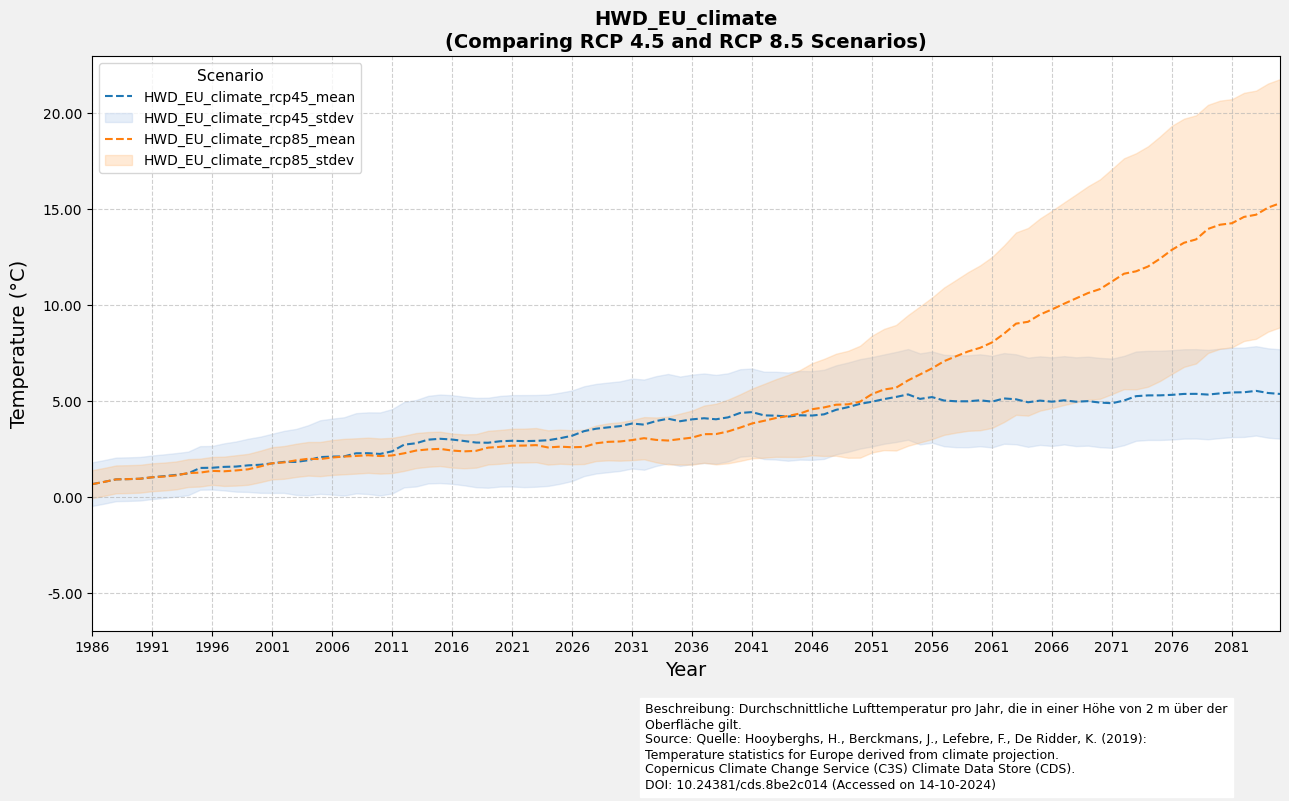

In [22]:
if __name__ == "__main__":
    # Single dataset variable
    # This code fails for Cold Spell Days because of empty data for Konstanz
    plot_line_and_shade(filtered_df_average=filtered_df_average,
                        variable_name_list=[f"{nc_files[0]['variable_name']}"])

### 6.2 Heatmap

In [23]:
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import numpy as np

def main_plt_plot(
        nc_file=nc_file,
        selected_year=None,
        bounding_box=None):
    
    # Open the NetCDF dataset
    nc_dataset = nc.Dataset(nc_file['path'], mode='r')

    # Access latitude and longitude variables
    lat = nc_dataset.variables['lat'][:]
    lon = nc_dataset.variables['lon'][:]

    if bounding_box:
        # Find indices for the bounding box
        lat_indices = np.where((lat >= bounding_box[1]) & (lat <= bounding_box[3]))[0]
        lon_indices = np.where((lon >= bounding_box[0]) & (lon <= bounding_box[2]))[0]

        # Subset latitude and longitude
        lat_subset = lat[lat_indices]
        lon_subset = lon[lon_indices]
    else:
        lat_indices = slice(None)
        lon_indices = slice(None)

        lat_subset = lat
        lon_subset = lon

    # Extract variable data
    variable_name = nc_file['variable_name']
    variable_data = nc_dataset.variables[variable_name][..., lat_indices, lon_indices]

    var_units = getattr(nc_dataset.variables[variable_name], "units", "N/A")

    # Calculate vmin, vmax, and bins
    if selected_year < 1986:
        year_index = 0
        year = 1985
    elif selected_year > 2085:
        year_index = -1
        year = 2085
    else:
        year_index = selected_year-1986
        year = selected_year
    print(year_index)
    band_data = variable_data[year_index]
    band_data_nonan = band_data[~np.isnan(band_data)]

    vmin = np.nanpercentile(band_data_nonan, 1)
    vmax = np.nanpercentile(band_data_nonan, 99)

    def dynamic_round(value):
        # Determine the magnitude of the value
        order_of_magnitude = np.floor(np.log10(abs(value)))
        
        # Use this magnitude to dynamically choose precision
        if order_of_magnitude < -2:  # Values less than 0.01
            return round(value, 3)
        elif order_of_magnitude < -1:  # Values between 0.01 and 1
            return round(value, 2)
        elif order_of_magnitude < 0:  # Values between 1 and 10
            return round(value, 1)
        else:  # Values 10 or larger
            return round(value)
    
    # Apply dynamic rounding to vmin and vmax
    vmin = dynamic_round(vmin)
    vmax = dynamic_round(vmax)

    bins = 10
    interval = (vmax - vmin) / bins
    print(vmin, vmax, interval)
    
    # Create a 2D grid for plotting
    lon_grid, lat_grid = np.meshgrid(lon_subset, lat_subset)

    # Create the plot
    fig, ax = plt.subplots(
        figsize=(12, 8),
        facecolor='#f1f1f1',
        edgecolor='k',
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Add map features
    ax.coastlines(edgecolor='black', linewidth=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1.5)

    # Create a colormesh plot
    cmap = plt.get_cmap("viridis", bins)
    pcm = ax.pcolormesh(
        lon_grid,
        lat_grid,
        band_data,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        shading='auto',
        vmin=vmin,
        vmax=vmax,
        )
    
    # Add a colorbar
    ticks = np.linspace(vmin, vmax, num=bins + 1)
    cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.02, ticks=ticks)
    cbar.set_label(f"{variable_name} ({var_units})", fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    
    # Add grid lines
    gl = ax.gridlines(draw_labels=True,
                      crs=ccrs.PlateCarree(),
                      linewidth=0.8,
                      color='gray',
                      alpha=0.7,
                      linestyle='--')
    gl.top_labels = False 
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    
    # Add title and labels
    fig.text(0.5, 0.0, 'Longitude', ha='center', fontsize=14)
    fig.text(0.06, 0.5, 'Latitude', va='center', rotation='vertical', fontsize=14)
    ax.set_aspect("equal")

    # Add a title
    ax.set_title(f"Heat Wave Days ({variable_name}), {year}", fontsize=14)

    # Save or display the plot
    plt.tight_layout()
    
    # Show the plot
    plt.show()

4
0.4 1 0.060000002


C:\Users\ShaileshShrestha\anaconda3\envs\myenv\lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


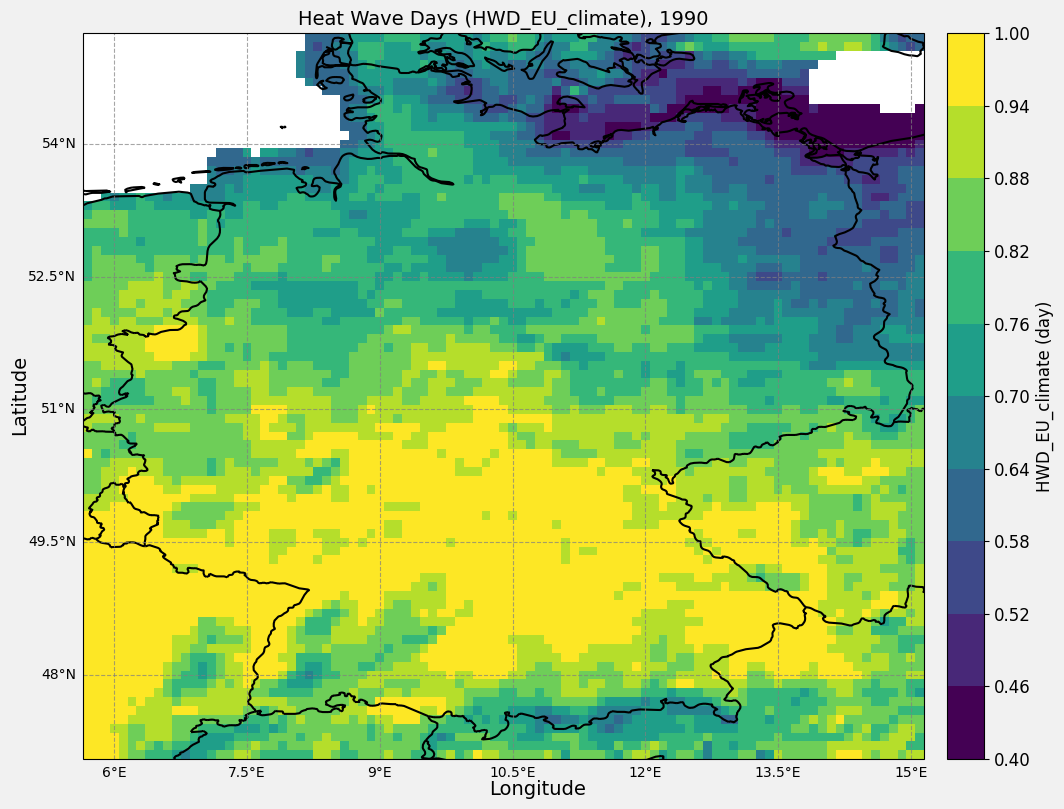

In [24]:
if __name__ == "__main__":
    # Example usage
    main_plt_plot(nc_file=nc_files[0],
                  selected_year=1990,
                  )